## Setup the Google Colab

In [1]:
import os
from pathlib import Path
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
%env DATA_DIRECTORY = C:\Workspace\Practice\Python\LeraningWorkspace\data

env: DATA_DIRECTORY=C:\Workspace\Practice\Python\LeraningWorkspace\data


In [ ]:
%env DATA_DIRECTORY = /content/drive/MyDrive/Task-3-Data Augmentation/data

env: DATA_DIRECTORY=/content/drive/MyDrive/Task-3-Data Augmentation/data


In [3]:
directory = os.environ.get("DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

C:\Workspace\Practice\Python\LeraningWorkspace\data


## Add some utility functions here

In [4]:
## Code to clean kaggle output folders
def remove_folder_contents(folder, recurse=False):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                if recurse is True:
                    remove_folder_contents(file_path)
                    os.rmdir(file_path)
                continue
        except Exception as e:
            print(e)

In [5]:
def checkPathExists(path):
  if not os.path.exists(path):
    print(f"Cannot access path: {path}")
  else:
    print (f"Path {path} accessible")

In [6]:
def buildCropDiseaseCountTuple(instanceFolder):
    # Name of Crop and Disease is the folder name so split it . Need to change the logic here based on the data source . Much Pain!!
    # Count will be just samples within the folder
    str_name = str(instanceFolder.name)
    str_name = str_name.replace(" leaf", "").rstrip()
    print(str_name)
    values = str_name.split(" ", 2)
    f = instanceFolder.rglob('*')
    counts = np.unique([x.parent for x in f], return_counts=True)[1]
    if len(values) == 1:
        values = ['Coffee', values[0]]
        #values.append('healthy')
    return (values[0], values[1], counts[0].tolist())

In [7]:
def readFolderAndSaveDataFrame(DataFolder, classNames=None):
    '''
    Read the folder - Note the assumption here is that the images are already seperated into their respective class subfolders
    Example -
        <root>
            - <class 1>
                - <image 1>
                - <image 2>
            - <class 2>
                - <image 1>
                - <image 2>
    '''
    dataFolder = Path(f"{DataFolder}")
    dataList = []
    # Get all the folders within the path - The list of folders are the classes.
    if classNames != None:
        instancePathList = [f for f in dataFolder.iterdir() if f.is_dir() and f.name in classNames]
    else:
        instancePathList = [f for f in dataFolder.iterdir() if f.is_dir()]
    for classPath in instancePathList:
        dataList.append(buildCropDiseaseCountTuple(classPath))

    ## Make a DataFrame
    samplesDataFrame = pd.DataFrame(dataList, columns=['Crop', 'Disease', 'numberImages'])
    return samplesDataFrame

In [8]:
def generate_pie_plot(df, title="Categories", ax = None):
    proportions = []
    sz = len(df.Disease.unique())
    total = np.sum(df.numberImages)
    for c in range(sz):
        prop = df.numberImages[c]
        print(f"Proportion of data in class {df.Disease[c]} is {prop} : {prop/total*100:0.2f} %")
        proportions.append(prop)

    #colors = ['#003f5c', '#58508d' , '#bc5090', '#ff6361', '#ffa600']
    colors = ['gray', '#f8af3a', '#544ED5', '#71a2a5', '#bc5090']

    if ax is None:
        fig, ax = plt.subplots()
    ax.pie(proportions, labels=df.Disease, autopct='%1.1f%%', colors = colors, textprops={'color':"black"})
    ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    ax.set_title(title, color='black')

In [9]:
def saveImageDataAndMetaData(dataDir, outputDir, classNames):
    metadata_tuplelist = []
    if classNames != None:
      class_list = [x for x in dataDir.iterdir() if x.name in classNames]
    else:
      class_list = [x for x in dataDir.iterdir()]
    for c, class_ in enumerate(class_list):
        print(f"Tracking {class_}")
        for f, file in enumerate(class_.glob(f"*")):
            im = cv2.imread(str(file))
            h, w, ch = im.shape
            metadata_tuplelist.append((f"{file}", class_.name, h, w, ch))
    print(len(metadata_tuplelist))
    metadata_df = pd.DataFrame(metadata_tuplelist, columns=['FileName', 'ClassName', 'FrameHeight', 'FrameWidth', 'Channels'])
    print(metadata_df.shape)
    metadata_df.to_csv(outputDir.joinpath("coffeediseasedata.csv"))

In [10]:
## Load all the images and the keypoints
def LoadData(inputDir, imageSize):
    all_images = []
    all_classes = []
    all_ids = []
    for j, p in enumerate(inputDir.glob(f"*.csv")):
        df = pd.read_csv(p)
        sz = df.shape[0]
        for i in range(sz):
            file = df.iloc[i]['FileName']
            #img = cv2.imread(str(inputDir.joinpath(file)))
            #plt.imshow(img)
            #plt.show()
            all_classes.append(df.iloc[i]['ClassName'])
            #img = cv2.resize(img, (imageSize, imageSize))
            all_images.append(file)
            all_ids.append(file.split('.')[0])
    print(len(all_images))
    all_images = np.asarray(all_images)
    all_classes = np.asarray(all_classes)
    all_ids = np.asarray(all_ids)
    return all_images, all_classes, all_ids

## Get the coffee dataset

In [11]:
directory = os.environ.get("DATA_DIRECTORY")
ROOT_DIR = Path(tempfile.mkdtemp()) if directory is None else Path(directory)
print(ROOT_DIR)

C:\Workspace\Practice\Python\LeraningWorkspace\data


In [12]:
CLASSNAMES = ['Healthy', 'Cescospora', 'Miner', 'Phoma', 'Rust']

In [13]:
SINGLE_LEAVES_DATA_DIR = Path(root_dir).joinpath('002_strategy_just_single_leaves/train')

In [15]:
coffeedf = readFolderAndSaveDataFrame(SINGLE_LEAVES_DATA_DIR, CLASSNAMES)

Cescospora
Healthy
Miner
Phoma
Rust


In [16]:
coffeedf.head()

,Crop,Disease,numberImages
0,Coffee,Cescospora,200
1,Coffee,Healthy,738
2,Coffee,Miner,1009
3,Coffee,Phoma,826
4,Coffee,Rust,1671


Proportion of data in class Cescospora is 200 : 4.50 %
Proportion of data in class Healthy is 738 : 16.61 %
Proportion of data in class Miner is 1009 : 22.70 %
Proportion of data in class Phoma is 826 : 18.59 %
Proportion of data in class Rust is 1671 : 37.60 %


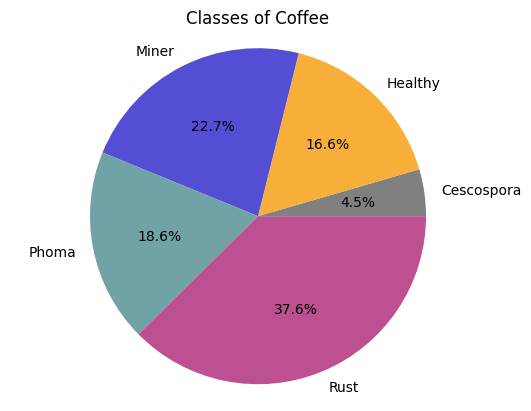

In [17]:
generate_pie_plot(coffeedf, 'Classes of Coffee')

Building a CSV metafile of image info that I will use to load the data later

In [18]:
saveImageDataAndMetaData(SINGLE_LEAVES_DATA_DIR, SINGLE_LEAVES_DATA_DIR, CLASSNAMES)

Tracking C:\Workspace\Practice\Python\LeraningWorkspace\data\002_strategy_just_single_leaves\train\Cescospora
Tracking C:\Workspace\Practice\Python\LeraningWorkspace\data\002_strategy_just_single_leaves\train\Healthy
Tracking C:\Workspace\Practice\Python\LeraningWorkspace\data\002_strategy_just_single_leaves\train\Miner
Tracking C:\Workspace\Practice\Python\LeraningWorkspace\data\002_strategy_just_single_leaves\train\Phoma
Tracking C:\Workspace\Practice\Python\LeraningWorkspace\data\002_strategy_just_single_leaves\train\Rust
4444
(4444, 5)


## Load the Corn Data for Training

In [14]:
IMAGE_SIZE = 256
META_DATA_FILE = SINGLE_LEAVES_DATA_DIR / 'coffeediseasedata.csv'
batch_size = 32

In [15]:
coffee_images, coffee_classes, coffee_ids = LoadData(SINGLE_LEAVES_DATA_DIR, IMAGE_SIZE)

4444


Split into training and validation images

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
train_images, val_images, train_id, val_id, train_class, test_class = \
train_test_split(coffee_images, coffee_ids, coffee_classes,
                 test_size=0.1, random_state=1234, shuffle=True, stratify=coffee_classes)

In [18]:
train_df = pd.DataFrame(np.array(np.unique(train_class, return_counts=True)).T, columns=['Disease', 'numberImages'])
test_df = pd.DataFrame(np.array(np.unique(test_class, return_counts=True)).T, columns=['Disease', 'numberImages'])
train_df['numberImages'] = train_df['numberImages'].astype('int32')
test_df['numberImages'] = test_df['numberImages'].astype('int32')

Proportion of data in class Cescospora is 180 : 4.50 %
Proportion of data in class Healthy is 664 : 16.60 %
Proportion of data in class Miner is 908 : 22.71 %
Proportion of data in class Phoma is 743 : 18.58 %
Proportion of data in class Rust is 1504 : 37.61 %
Proportion of data in class Cescospora is 20 : 4.49 %
Proportion of data in class Healthy is 74 : 16.63 %
Proportion of data in class Miner is 101 : 22.70 %
Proportion of data in class Phoma is 83 : 18.65 %
Proportion of data in class Rust is 167 : 37.53 %


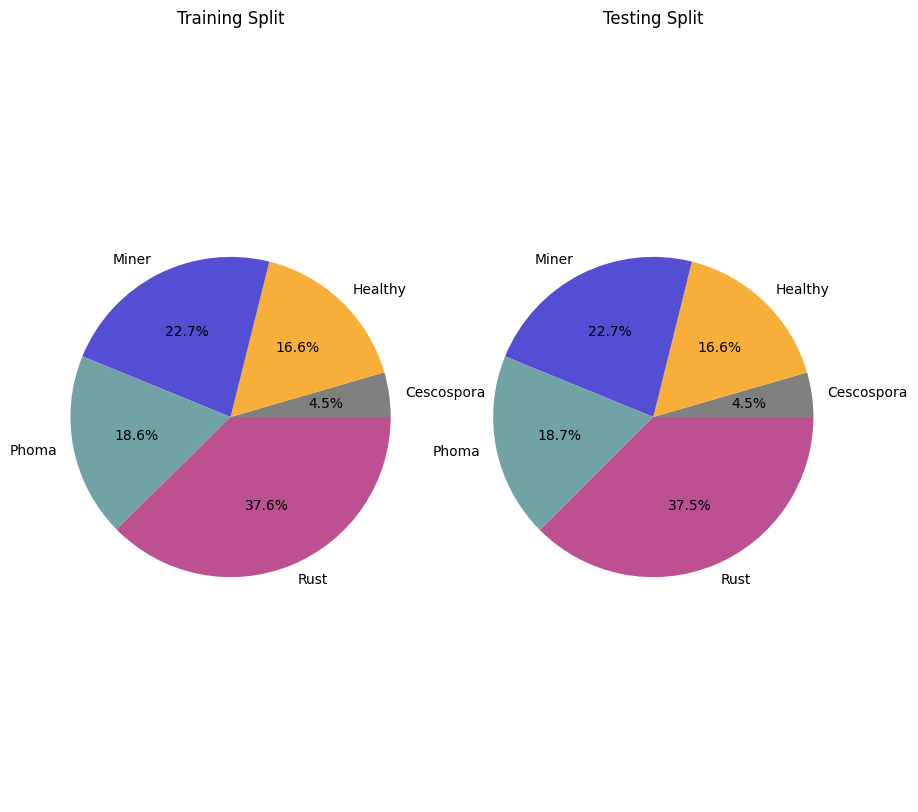

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))
generate_pie_plot(train_df, title="Training Split", ax=ax[0])
generate_pie_plot(test_df, title="Testing Split", ax=ax[1])

In [20]:
import tensorflow as tf

Visualize some sample input images

In [21]:
def VisualizeSampleImages(image, convert=False):
    ## Note convert from BGR to RGB here
    if convert:
      plt.imshow(image[:,:,::-1])
    else:
      plt.imshow(image)
    #plt.show()

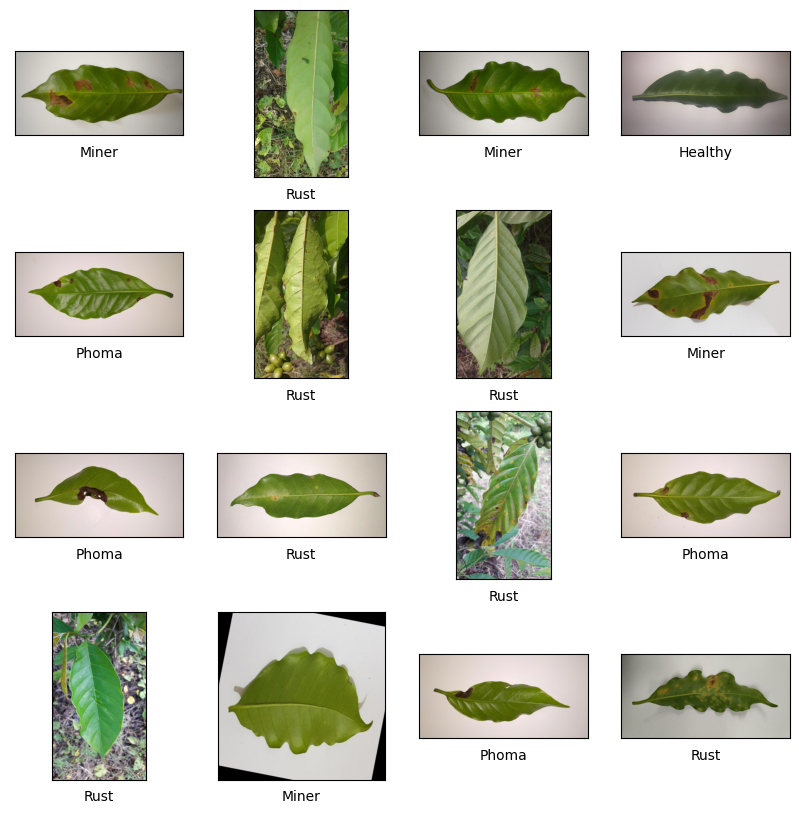

In [22]:
plt.subplots(4, 4, figsize=(10,10))
num_total = coffee_images.shape[0]
for i, k in enumerate(np.random.randint(num_total, size=16)):
    image = cv2.imread(coffee_images[k])
    plt.subplot(4, 4, i+1)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    VisualizeSampleImages(image, True)
    plt.xlabel(coffee_classes[k])

Make a Tensorflow dataset

In [23]:
train_ds = tf.data.Dataset.list_files(train_images.tolist(), shuffle=False)
train_ds = train_ds.shuffle(train_df.numberImages.sum(), reshuffle_each_iteration=False)

In [24]:
val_ds = tf.data.Dataset.list_files(val_images.tolist(), shuffle=False)

In [25]:
for f in train_ds.take(5):
  print(f.numpy())

b'C:\\Workspace\\Practice\\Python\\LeraningWorkspace\\data\\002_strategy_just_single_leaves\\train\\Miner\\11_jpg.rf.09e65e129b552d53702907fcbe7f914c.jpg'
b'C:\\Workspace\\Practice\\Python\\LeraningWorkspace\\data\\002_strategy_just_single_leaves\\train\\Rust\\1367_jpg.rf.a04abbb634cfb58e6a3ff28d97f572aa.jpg'
b'C:\\Workspace\\Practice\\Python\\LeraningWorkspace\\data\\002_strategy_just_single_leaves\\train\\Miner\\cld-kaggle-train-miner (97).jpg'
b'C:\\Workspace\\Practice\\Python\\LeraningWorkspace\\data\\002_strategy_just_single_leaves\\train\\Phoma\\cld-kaggle-train-phoma (302).jpg'
b'C:\\Workspace\\Practice\\Python\\LeraningWorkspace\\data\\002_strategy_just_single_leaves\\train\\Rust\\C10P8E2.jpg'


In [26]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

3999
445


In [27]:
## Boilerplate
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == CLASSNAMES
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])

def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

def configure_for_performance(ds):
  #ds = ds.apply(tf.data.experimental.unbatch())
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

In [28]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [29]:
for image, label in train_ds.take(5):
  #print("File name: ", filename.numpy())
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (256, 256, 3)
Label:  2
Image shape:  (256, 256, 3)
Label:  4
Image shape:  (256, 256, 3)
Label:  2
Image shape:  (256, 256, 3)
Label:  3
Image shape:  (256, 256, 3)
Label:  4


In [30]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

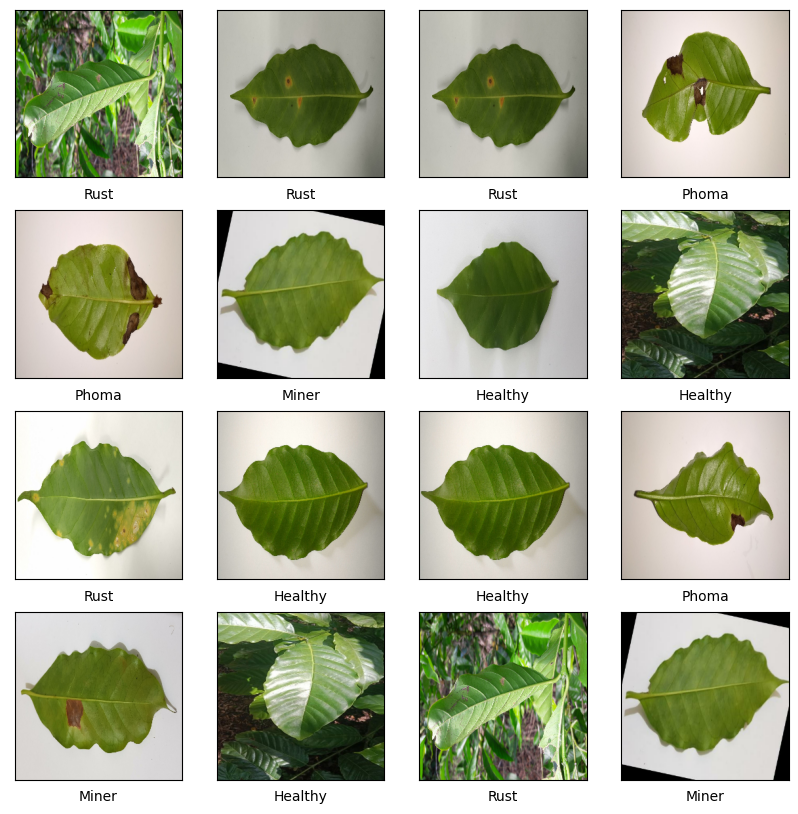

In [31]:
image_batch, label_batch = next(iter(train_ds))

plt.subplots(4, 4, figsize=(10,10))
for i, k in enumerate(np.random.randint(batch_size, size=16)):
    plt.subplot(4, 4, i+1)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    VisualizeSampleImages(image_batch[k].numpy().astype("uint8"))
    plt.xlabel(CLASSNAMES[label_batch[k]])

### Build the Coffee Disease Classification model

MobileNetv2

In [32]:
# Models
from keras.models import Model
from tensorflow.keras.applications import MobileNetV2, mobilenet_v2
from keras.layers import Input, Dropout, SeparableConv2D, Dense, Flatten, BatchNormalization

In [33]:
backbone = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)
backbone.trainable = False

In [34]:
MODEL_NAME = 'Coffee_Disease_Classifier'
#InputLayer
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="InputLayer")
# Preprocess Input
x = mobilenet_v2.preprocess_input(inputs)
# MobileNetV2 Backbone
x = backbone(x)
# Regularization
x = Dropout(0.3, name="DropOut")(x)
# FCN
x = Flatten()(x)
x = Dense(1024, activation='relu', name="Dense_FCN_1")(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', name="Dense_FCN_2")(x)
x = Dropout(0.15)(x)
# Outputs
outputs = Dense(5, activation='softmax')(x)
#Model
model_1 = Model(inputs, outputs, name=MODEL_NAME)
model_1.summary()

Model: "Coffee_Disease_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 DropOut (Dropout)           (None, 8, 8, 1280)        0         
                                         

In [35]:
for image, label in val_ds.take(1):
  print(image.numpy().shape)

(32, 256, 256, 3)


In [36]:
# Callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
# Optimizer
from tensorflow.keras.optimizers import Adam

In [37]:
class ShowProgress(Callback):

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 20 == 0:
            plt.subplots(1, 2, figsize=(10, 10))
            for image, label in train_ds.take(1):
                pred_kps = self.model.predict(image)
                plt.subplot(1, 2, 1)
                plt.gca().set_yticklabels([])
                plt.gca().set_xticklabels([])
                plt.gca().set_xticks([])
                plt.gca().set_yticks([])
                VisualizeSampleImages(image[0].numpy().astype("uint8"))
                plt.xlabel(f"Predicted: {CLASSNAMES[np.argmax(pred_kps, axis=1)[0]]}/ GT: {CLASSNAMES[label[0]]}")
                #plt.xlabel(f"GT:{input_class[k]}")
            plt.show()

In [38]:
WEIGHT_DIR = Path('/content/drive/MyDrive/CoffeeCheckpoints')
WEIGHT_DIR.mkdir(parents=True, exist_ok=True)

Epoch 1/10
1/1 [==============================] - 1s 1s/steps - loss: 0.8325 - accuracy: 0.76


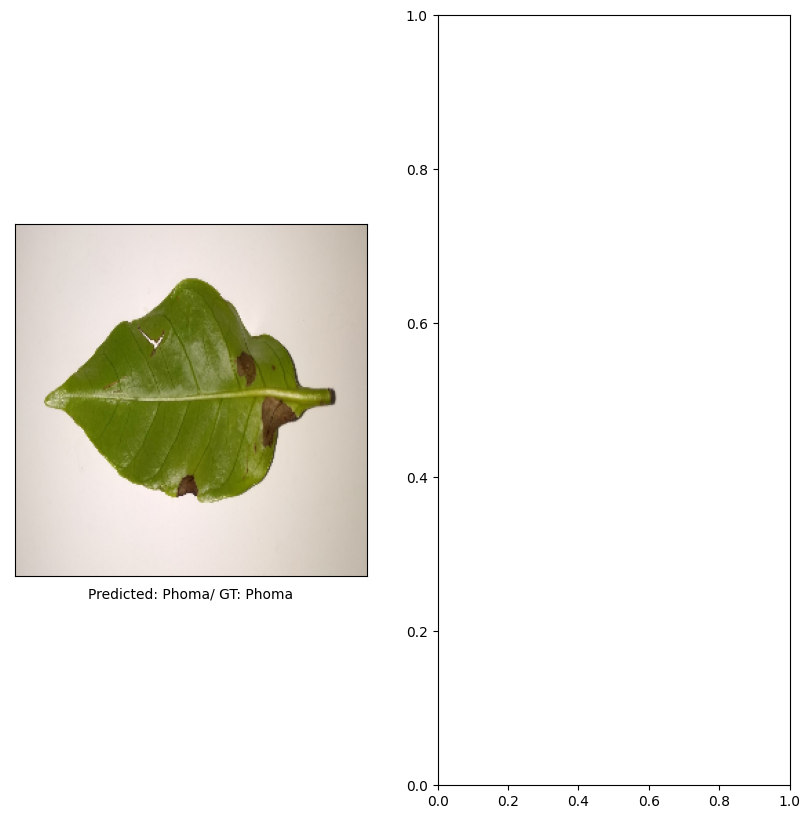

125/125 [==============================] - 49s 303ms/step - loss: 0.8325 - accuracy: 0.7602 - val_loss: 0.4178 - val_accuracy: 0.8517
Epoch 2/10
125/125 [==============================] - 22s 174ms/step - loss: 0.2785 - accuracy: 0.9065 - val_loss: 0.3285 - val_accuracy: 0.8652
Epoch 3/10
125/125 [==============================] - 18s 147ms/step - loss: 0.1258 - accuracy: 0.9585 - val_loss: 0.3549 - val_accuracy: 0.8472
Epoch 4/10
125/125 [==============================] - 19s 149ms/step - loss: 0.0924 - accuracy: 0.9702 - val_loss: 0.3496 - val_accuracy: 0.8764
Epoch 5/10
125/125 [==============================] - 18s 147ms/step - loss: 0.0745 - accuracy: 0.9762 - val_loss: 0.3429 - val_accuracy: 0.8831
Epoch 6/10
125/125 [==============================] - 18s 145ms/step - loss: 0.0571 - accuracy: 0.9845 - val_loss: 0.3430 - val_accuracy: 0.8921
Epoch 7/10
125/125 [==============================] - 18s 146ms/step - loss: 0.0478 - accuracy: 0.9875 - val_loss: 0.3297 - val_accuracy: 0.8

In [39]:
EPOCHS=10
# Compile
model_1.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(learning_rate=1e-4),
                metrics=['accuracy']) # Lower the Learning Rate better the results.
checkpoint_path = str(WEIGHT_DIR)+MODEL_NAME+"-{epoch:04d}.ckpt"
# Model Training
callbacks = [
#     EarlyStopping(patience=7, restore_best_weights=True), # keep the patience low.
    ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True),
    ShowProgress()
]
weights = {0:(4444/(4*664)), 1:(4444/(4*180)), 2:(4444/(4*908)), 3:(4444/(4*743)), 4:(4444/(4*1504))}
history = model_1.fit(train_ds,
                      validation_data=val_ds,
                      epochs=EPOCHS,
                      steps_per_epoch = 125,
                      class_weight=weights,
                      callbacks=callbacks)

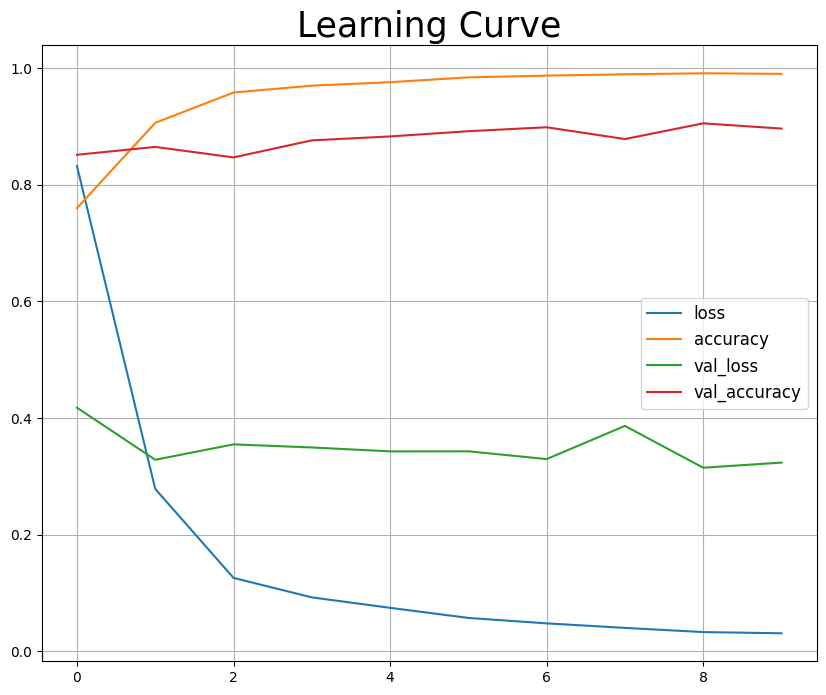

In [40]:
lc = pd.DataFrame(history.history)
lc.plot(figsize=(10,8))
plt.title("Learning Curve", fontsize=25)
plt.grid()
plt.legend(fontsize=12)
plt.show()

### Error Analysis

In [41]:
from sklearn.metrics import accuracy_score
def Accuracy_ConfusionMatrix(actual, predicted, categories):
    print(f"Accuracy of model: {accuracy_score(actual, predicted)}")
    confusion_matrix = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'])
    print(confusion_matrix)
    print("Sensitivity of model for individual classes")
    class_sum = np.sum(confusion_matrix, axis=1)
    for c,i in enumerate(categories):
        print(f"Class {i} : {confusion_matrix.iloc[c][c]/class_sum[c]}")

In [42]:
def get_predicted_classes(data_images, model):
    '''
    data_images: shape [None, 112, 112, 3]
    '''
    data_kps = model.predict(data_images)
    return data_kps

In [46]:
def generateMatrix(dataset):
    ds_labels=[]
    pred_labels=[]
    for images, labels in dataset:
        ds_labels.extend(labels.numpy().tolist()) # or labels.numpy().argmax() for int labels
        precited_train_classes = get_predicted_classes(images, model_1)
        pred_labels.extend(np.argmax(precited_train_classes, axis = 1))
    Accuracy_ConfusionMatrix(ds_labels, pred_labels, CLASSNAMES)
    return ds_labels, pred_labels

In [47]:
train_true, train_pred = generateMatrix(train_ds)

1/1 [==============================] - 0s 76ms/step
Accuracy of model: 0.9967491872968242
Predicted    0    1    2    3     4
Actual                             
0          663    0    0    0     1
1            0  180    0    0     0
2            0    0  904    0     4
3            0    0    0  743     0
4            6    0    2    0  1496
Sensitivity of model for individual classes
Class Healthy : 0.9984939759036144
Class Cescospora : 1.0
Class Miner : 0.9955947136563876
Class Phoma : 1.0
Class Rust : 0.9946808510638298


In [52]:
from sklearn.metrics import classification_report

print(classification_report(train_true, train_pred, target_names=CLASSNAMES))

              precision    recall  f1-score   support

     Healthy       0.99      1.00      0.99       664
  Cescospora       1.00      1.00      1.00       180
       Miner       1.00      1.00      1.00       908
       Phoma       1.00      1.00      1.00       743
        Rust       1.00      0.99      1.00      1504

    accuracy                           1.00      3999
   macro avg       1.00      1.00      1.00      3999
weighted avg       1.00      1.00      1.00      3999



In [49]:
val_true, val_pred = generateMatrix(val_ds)

1/1 [==============================] - 0s 103ms/step
Accuracy of model: 0.8966292134831461
Predicted   0   1   2   3    4
Actual                        
0          65   2   2   0    5
1           0  18   0   0    2
2           1   0  85   0   15
3           0   0   1  81    1
4           5   4   8   0  150
Sensitivity of model for individual classes
Class Healthy : 0.8783783783783784
Class Cescospora : 0.9
Class Miner : 0.8415841584158416
Class Phoma : 0.9759036144578314
Class Rust : 0.8982035928143712


In [51]:
print(classification_report(val_true, val_pred, target_names=CLASSNAMES))

              precision    recall  f1-score   support

     Healthy       0.92      0.88      0.90        74
  Cescospora       0.75      0.90      0.82        20
       Miner       0.89      0.84      0.86       101
       Phoma       1.00      0.98      0.99        83
        Rust       0.87      0.90      0.88       167

    accuracy                           0.90       445
   macro avg       0.88      0.90      0.89       445
weighted avg       0.90      0.90      0.90       445

